In [12]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *


import scipy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
FEATURE_DIMS = ["Color", "Shape", "Pattern"]
PRE_INTERVAL = 1000
POST_INTERVAL = 1000
INTERVAL_SIZE = 100
SMOOTH = 1
EVENT = "StimOnset"
OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze

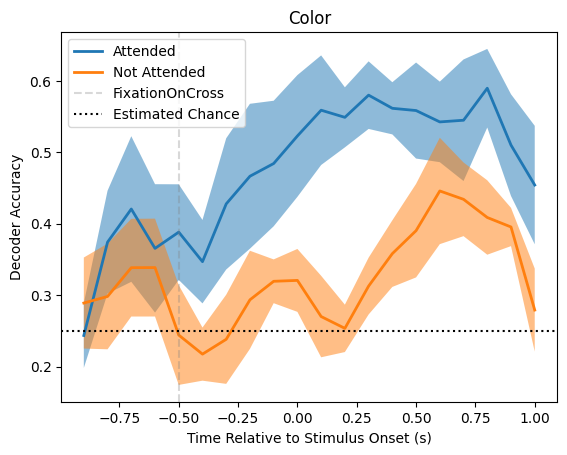

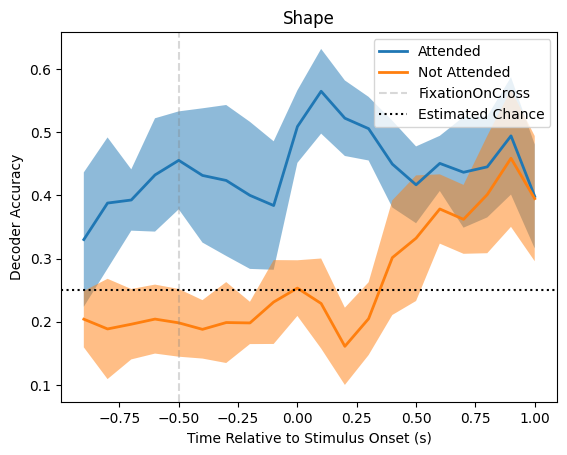

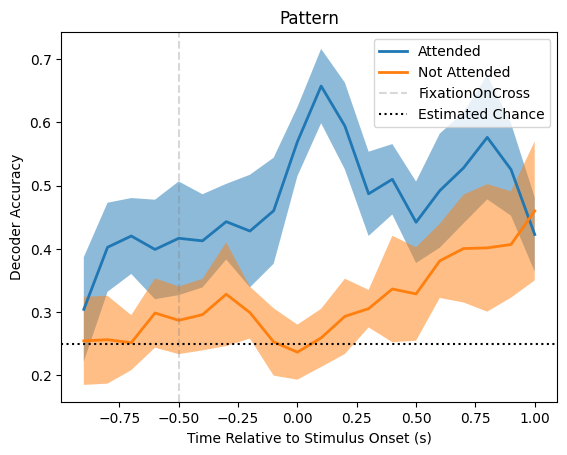

In [14]:
for dim in FEATURE_DIMS:
    fig, ax = plt.subplots()
    attended_accs = np.load(os.path.join(OUTPUT_DIR, f"{dim}_StimOnset_attended_test_accs.npy"))
    not_attended_accs = np.load(os.path.join(OUTPUT_DIR, f"{dim}_StimOnset_not_attended_test_accs.npy"))
    visualization_utils.visualize_accuracy_across_time_bins(
        attended_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Attended",
        right_align=True, 
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        not_attended_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Not Attended",
        right_align=True, 
    )
    # # add grey band for selection period
    # ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # # add dotted line for feedback start
    ax.axvline(-0.5, alpha=0.3, color='gray', linestyle='dashed', label="FixationOnCross")
    # # add estimated chance
    ax.axhline(1/4, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_title(dim)
    ax.legend()
    ax.set_xlabel("Time Relative to Stimulus Onset (s)")
    ax.set_ylabel("Decoder Accuracy")